# Лабораторная работа №3. Бинарная сегментация избражений
---
Кабанов Евгений, РИМ-281226

Марго Бабайлова, РИМ-281226

<h2 style="color:#c2ba4a;">Внимание</h2>
<p style="color:#c2ba4a;">Данные, полученные в лабороторной являются неадекватными, тк из исходного набора данных использовалось только некоторые картинки и обучение длится малое количество эпох
    <br /><b>Гипотетически</b>, все работает. Для получения корректных результатов необходимо предоставить полный набор данных и отрегулировать параметры ниже </p>

In [116]:
TOTAL_EPOCHS = 1

В работе реализована тренировка сверточной нейронной сети Unet для сегментации левого желудочка на УЗИ изображениях сердца.

In [49]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (13,8)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Директория датасета состоит из двух директорий, в одной лежат изображения, в другой лежат разметка.

In [4]:
path = '/Users/spbravo/Downloads/drive-download-20191124T160610Z-001/train'
os.listdir(path)

['images', 'masks']

Необходимо собрать все изображения и разметки из директорий

In [6]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'images':
        img_pathes = pathes
    elif folder == 'masks':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

Реализуем класс Dataset

In [24]:
import torch
from torch.utils import data

T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    def __init__(self, path, subset = 'train', transform = None):

        for folder in os.listdir(path):
            pathes = []
            for pth, dirs, files in os.walk(os.path.join(path, folder)):
                for file in files:
                    pathes.append(os.path.join(pth, file))
            if folder == 'images':
                img_pathes = pathes
            elif folder == 'masks':
                lbl_pathes = pathes
   
        img_pathes.sort()
        lbl_pathes.sort()
        
        items = list(zip(img_pathes, lbl_pathes))
        
        if subset == 'train':
            self.items = items[: int(.7 * len(items))]
        elif subset == 'valid':
            self.items = items[int(.7 * len(items)): int(.9 * len(items))]
        elif subset == 'test':
            self.items = items[int(.9 * len(items)):]
            
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img_name, msk_name = self.items[index]

        image = Image.open(img_name)
        mask = Image.open(msk_name).convert('L')

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

Визаулизируем УЗИ-кадры и бинарные маски для кадров.

In [62]:
data = Dataset(path, subset='train', transform=None)

In [51]:
img, msk = data[0]

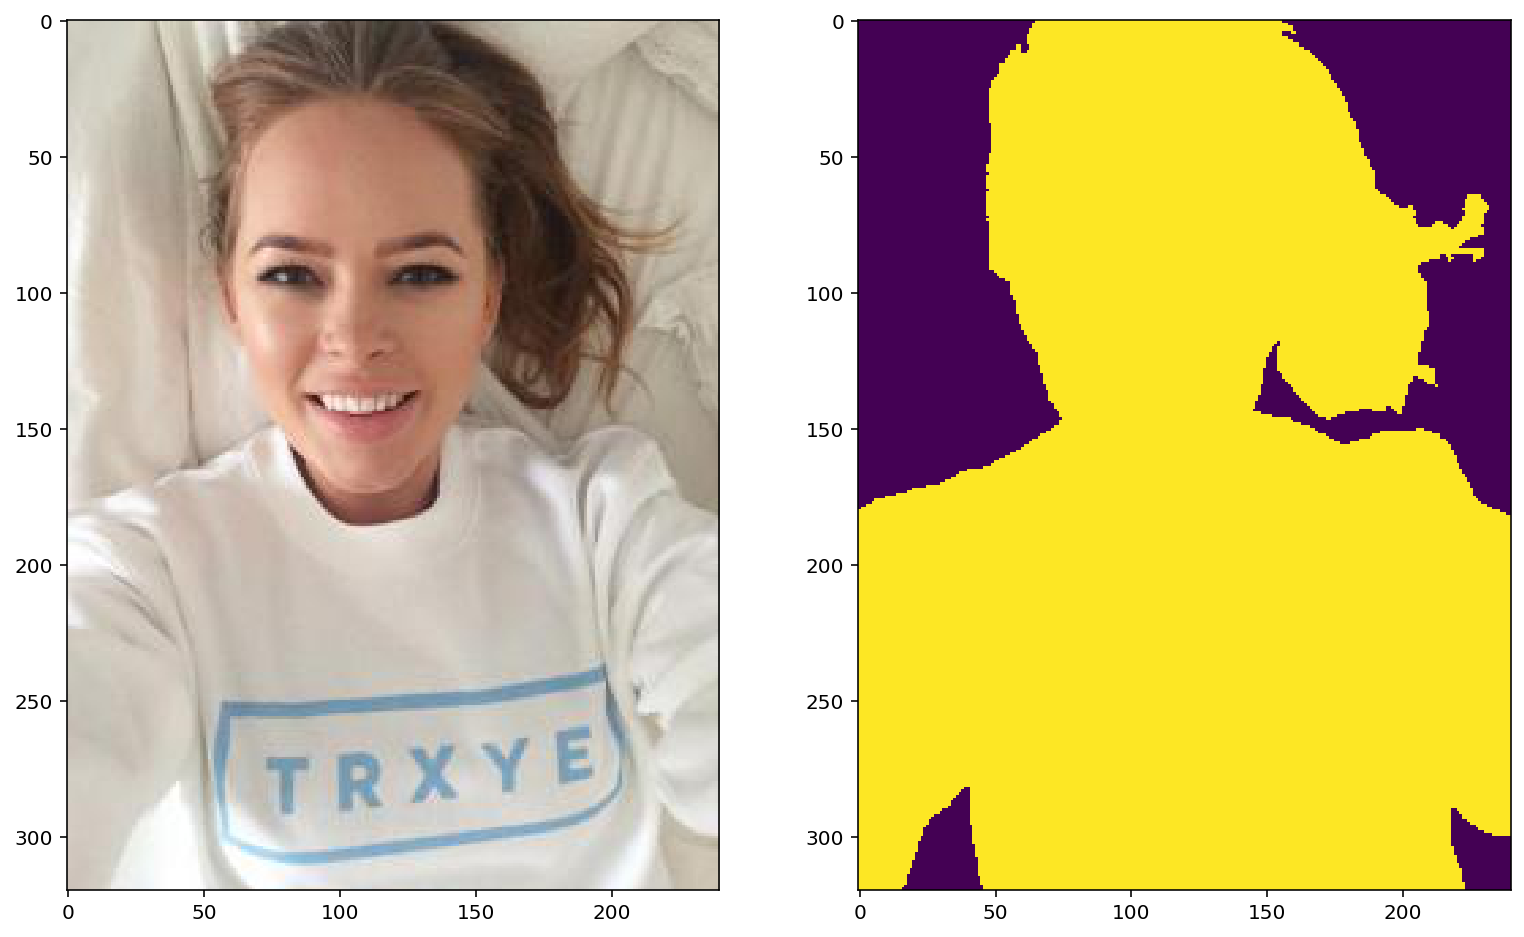

In [50]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(img)
axs[1].imshow(msk)

In [72]:
train_data = Dataset(path, subset='train', transform=T)
valid_data = Dataset(path, subset='valid', transform=T)
test_data = Dataset(path, subset='test', transform=T)

In [75]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=16, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False)

Используем модель Unet для сегментации снимков из библиотеки segmentation_models (https://github.com/qubvel/segmentation_models.pytorch).

In [114]:
model_labels = ['resnet18', 'resnet34', 'resnet50', 'dpn68', 'dpn98', 'vgg13']

## Encoder: resnet18

### Функция ошибки бинарная кроссэнтропия

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/spbravo/.cache/torch/checkpoints/resnet18-5c106cde.pth
100.0%



Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00,  7.07it/s, bce_loss - 1.508, iou - 0.6282, f-score - 0.7703] 


### Функция ошибки Dice


Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s, bce_dice_loss - 2.551, iou - 0.6272, f-score - 0.7694]


### Визуализация данных

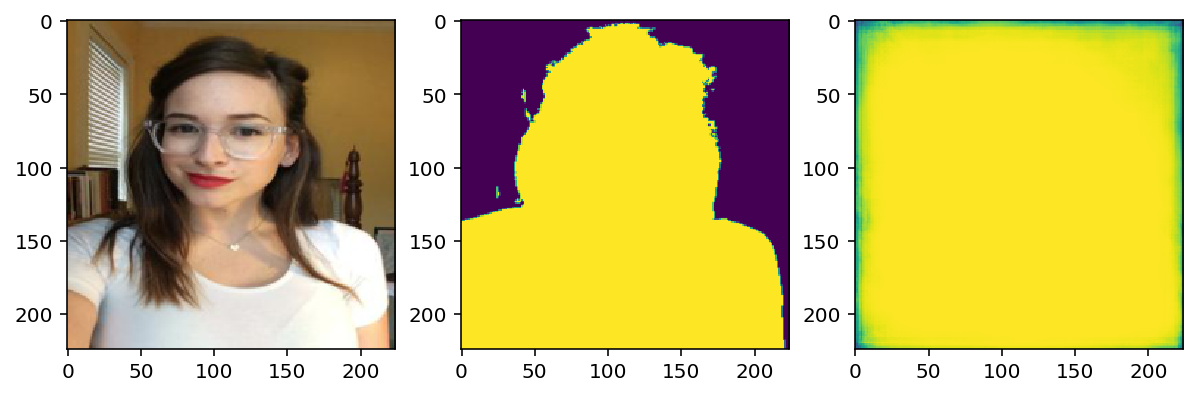

---

## Encoder: resnet34

### Функция ошибки бинарная кроссэнтропия


Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s, bce_loss - 1.132, iou - 0.009069, f-score - 0.01793]


### Функция ошибки Dice


Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00,  4.80it/s, bce_dice_loss - 1.923, iou - 0.002607, f-score - 0.005168]


### Визуализация данных

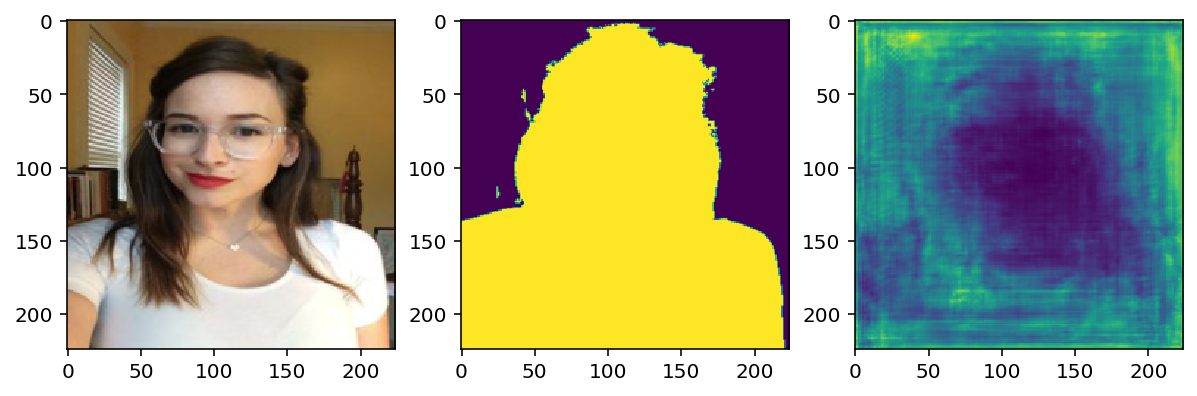

---

## Encoder: resnet50

### Функция ошибки бинарная кроссэнтропия


Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00,  3.58it/s, bce_loss - 0.6236, iou - 0.6329, f-score - 0.7735]


### Функция ошибки Dice


Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00,  5.33it/s, bce_dice_loss - 1.126, iou - 0.466, f-score - 0.6166]  


### Визуализация данных

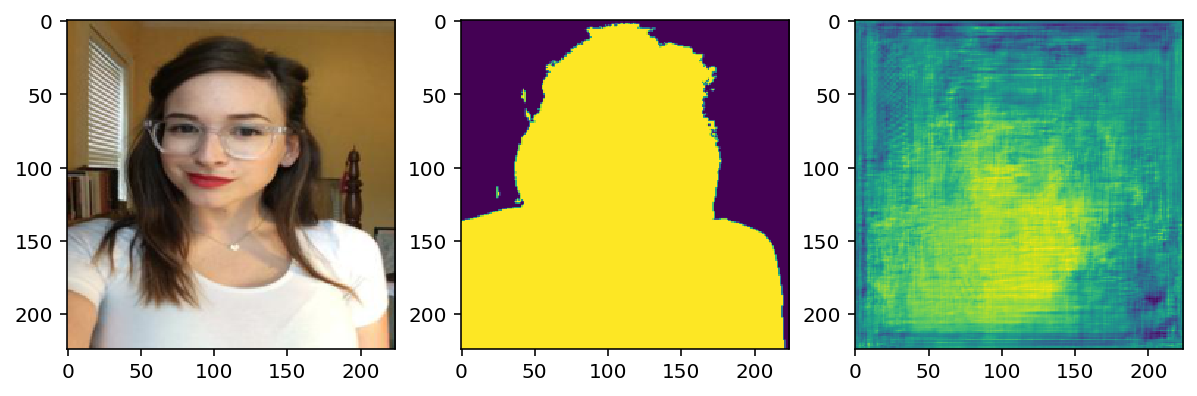

---

## Encoder: dpn68

### Функция ошибки бинарная кроссэнтропия

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/dpn68-4af7d88d2.pth" to /Users/spbravo/.cache/torch/checkpoints/dpn68-4af7d88d2.pth
100.0%



Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s, bce_loss - 0.9244, iou - 0.6279, f-score - 0.77]


### Функция ошибки Dice


Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s, bce_dice_loss - 0.9286, iou - 0.6234, f-score - 0.7676]


### Визуализация данных

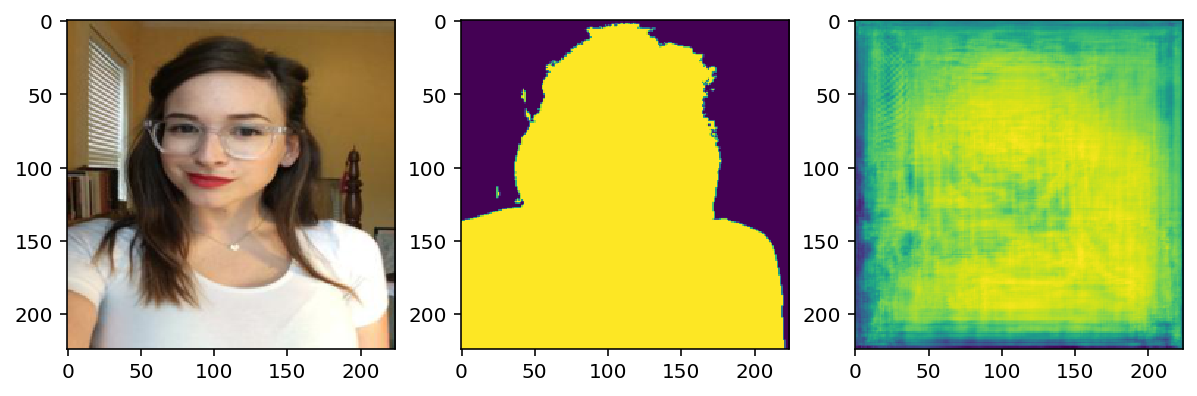

---

## Encoder: dpn98

### Функция ошибки бинарная кроссэнтропия

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/dpn98-722954780.pth" to /Users/spbravo/.cache/torch/checkpoints/dpn98-722954780.pth
100.0%



Epoch: 1
valid: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s, bce_loss - 0.9429, iou - 0.6347, f-score - 0.7757]


### Функция ошибки Dice


Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s, bce_dice_loss - 2.234, iou - 0.6273, f-score - 0.7695]


### Визуализация данных

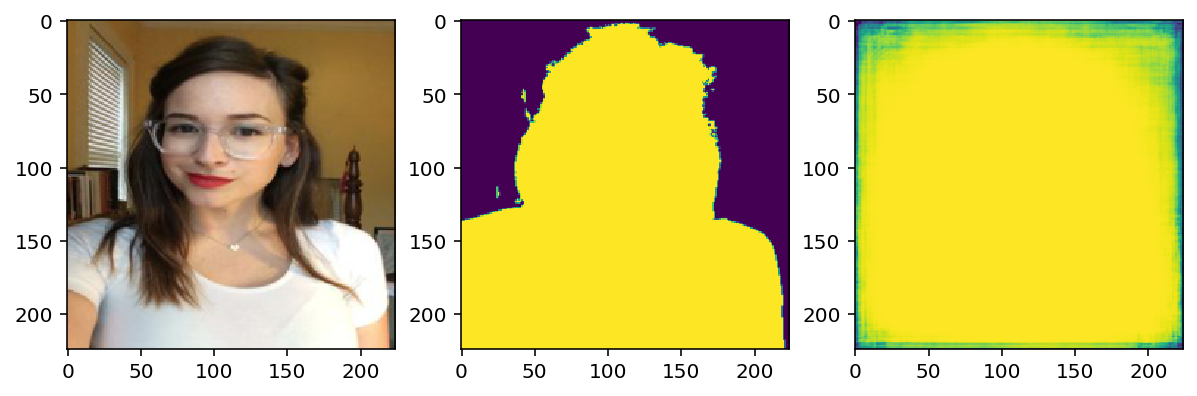

---

## Encoder: vgg13

### Функция ошибки бинарная кроссэнтропия

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /Users/spbravo/.cache/torch/checkpoints/vgg13-c768596a.pth
100.0%



Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s, bce_loss - 0.6195, iou - 0.583, f-score - 0.7363]


### Функция ошибки Dice


Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00,  3.83it/s, bce_dice_loss - 1.016, iou - 0.5844, f-score - 0.7347] 


### Визуализация данных

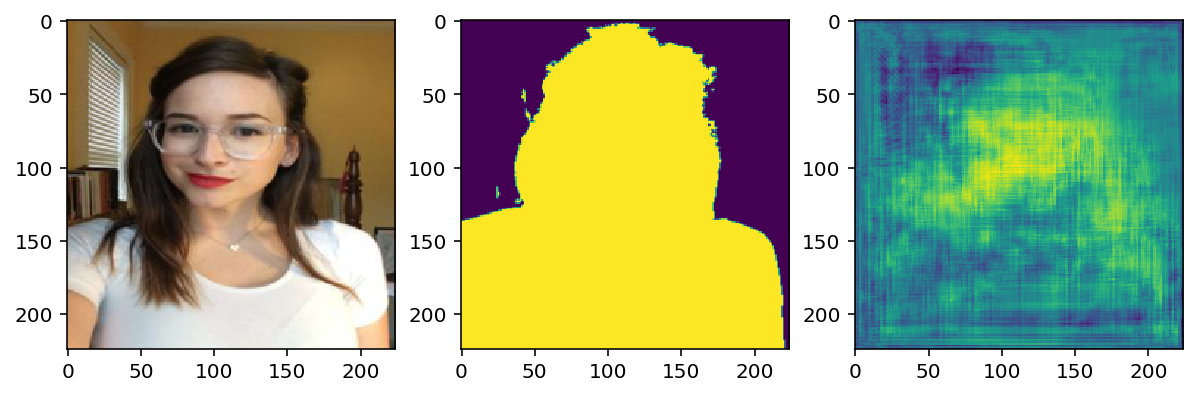

---

In [115]:
import segmentation_models_pytorch as smp
from torch import nn 
from IPython.display import display, Markdown

for model_name in model_labels:
    
    display(Markdown("## Encoder: " + str(model_name)))
    
    display(Markdown("### Функция ошибки бинарная кроссэнтропия"))
            
    model = smp.Unet(model_name).to(device)
            
    loss = nn.BCEWithLogitsLoss()
    loss.__name__ = 'bce_loss'
    metrics = [
        smp.utils.metrics.IoUMetric(eps=1.),
        smp.utils.metrics.FscoreMetric(eps=1.),
    ]

    optimizer = torch.optim.Adam([
        {'params': model.decoder.parameters(), 'lr': 1e-3},     

        {'params': model.encoder.parameters(), 'lr': 1e-5},  
    ])
            
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=device,
        verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=device,
        verbose=True,
    )
            
    max_score = 0

    for i in range(0, TOTAL_EPOCHS):

        print('\nEpoch: {}'.format(i + 1))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        # do something (save model, change lr, etc.)
    #     if max_score < valid_logs['iou']:
    #         max_score = valid_logs['iou']
    #         torch.save(model, './best_model.pth')
    #         print('Model saved!')

        if i == 5:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')
            
    valid_epoch.run(test_loader)
            
            
    display(Markdown("### Функция ошибки Dice"))
            
    model = smp.Unet().to(device)

    loss = smp.utils.losses.BCEDiceLoss(eps=1.)

    metrics = [
        smp.utils.metrics.IoUMetric(eps=1.),
        smp.utils.metrics.FscoreMetric(eps=1.),
    ]

    optimizer = torch.optim.Adam([
        {'params': model.decoder.parameters(), 'lr': 1e-3},     

        {'params': model.encoder.parameters(), 'lr': 1e-5},  
    ])

    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=device,
        verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=device,
        verbose=True,
    )
            
    max_score = 0

    for i in range(0, TOTAL_EPOCHS):

        print('\nEpoch: {}'.format(i+1))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        # do something (save model, change lr, etc.)
    #     if max_score < valid_logs['iou']:
    #         max_score = valid_logs['iou']
    #         torch.save(model, './best_model.pth')
    #         print('Model saved!')

        if i == 5:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')
            
    valid_epoch.run(test_loader)
            
            
    display(Markdown('### Визуализация данных'))
            
    img, mask_true = test_data[0]
    mask_pred = torch.sigmoid(model(img.unsqueeze(0).to(device)))
            
    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.subplot(132)
    plt.imshow(mask_true.squeeze().numpy())
    plt.subplot(133)
    plt.imshow(mask_pred.squeeze().cpu().detach().numpy())
    plt.show()
            
    display(Markdown('---'))

## Задача

Натренировать Unet для сегментации людей на изображении. Использовать датасет 'person segmentation' по ссылке https://drive.google.com/open?id=1yi7Flk_Whidr2OZNdfmGkpgxbQPwIVtr.
Натрениройте несколько моделей Unet с различными энкодерами, проведите анализ качества полученных моделей. Сведите результаты в таблицу по всем моделям и для каждой подвиборке (train, valid, test). Приведите примеры кадров с людьми.